# Data Prep

This notebook contains preprocessing steps to normalize and prepare historical data from USGS and NOAA for training. It intakes multifaceted datapoints at arbitrary timesteps, interpolates, and outputs at the highest frequency found in the input data.

## Setup

In [20]:
import os

# import ish_parser
from ish_parser import ish_parser

# import pandas
import pandas as pd

# import matplotlib
%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]

## Load files

In [21]:
# load noaa data
noaa_raw = ''
for filename in [f for f in os.listdir('data') if '725145-54746-' in f]:
  print('Reading {}'.format(filename))
  with open('data/' + filename) as fp:
    noaa_raw += fp.read()
    fp.close()

# set usgs data filenames
gageheight_fp = 'data/gageheight.csv'
watertemp_fp = 'data/watertemp.csv'

Reading 725145-54746-2009
Reading 725145-54746-2008
Reading 725145-54746-2015
Reading 725145-54746-2012
Reading 725145-54746-2013
Reading 725145-54746-2014
Reading 725145-54746-2020
Reading 725145-54746-2018
Reading 725145-54746-2011
Reading 725145-54746-2016
Reading 725145-54746-2017
Reading 725145-54746-2010
Reading 725145-54746-2019
Reading 725145-54746-2021


## Create pd.DataFrame

In [22]:
# noaa

parser = ish_parser()
parser.loads(noaa_raw)

reports = parser.get_reports()
reports_dict = {}
for r in reports:
  airtemp = float(r.air_temperature.get_numeric())
  cloudcover = None
  if 'GD1' in r.additional().keys():
    cloudcover_str = r.get_additional_field('GD1').sky_cover_summation['coverage'].get_numeric()
    if cloudcover_str == '': cloudcover = 0
    else: cloudcover = float(cloudcover_str)
  precip = 0
  if 'AU1' in r.additional().keys():
    precip_str = r.get_additional_field('AU1').present_weather_array['precipitation']
    if precip_str == 'Drizzle': precip = 1
    elif precip_str == 'Rain': precip = 2
    elif precip_str in ['Snow', 'Snow Grains', 'Ice Crystals', 'Ice Pellets', 'Hail', 'Small Hail']: precip = 3

  reports_dict[pd.to_datetime(r.datetime)] = {
    'airtemp': airtemp,
    'cloudcover': cloudcover,
    'precip': precip
  }
noaa_df = pd.DataFrame.from_dict(reports_dict, orient='index')

print('===\nNOAA DataFrame\n', noaa_df.head())

# usgs

gageheight_df = pd.read_csv(gageheight_fp, sep='\t', skiprows=27, usecols=[2, 3, 4])
gageheight_df.drop(index=gageheight_df.index[0], axis='index', inplace=True)
gageheight_df['datetime_tz'] = pd.to_datetime(gageheight_df['datetime'] + ' ' + gageheight_df['tz_cd'])
gageheight_df.drop(columns=gageheight_df.columns[[0, 1]], axis=1, inplace=True)
gageheight_df.set_index(gageheight_df.columns[1], inplace=True)
gageheight_df[gageheight_df.columns[0]] = gageheight_df[gageheight_df.columns[0]].astype('float')

print('\n===\nUSGS Gage Height\n', gageheight_df.head())

watertemp_df = pd.read_csv(watertemp_fp, sep='\t', skiprows=28, usecols=[2, 3, 4])
watertemp_df.drop(index=watertemp_df.index[0], axis='index', inplace=True)
watertemp_df['datetime_tz'] = pd.to_datetime(watertemp_df['datetime'] + ' ' + watertemp_df['tz_cd'])
watertemp_df.drop(columns=watertemp_df.columns[[0, 1]], axis=1, inplace=True)
watertemp_df.set_index(watertemp_df.columns[1], inplace=True)
watertemp_df[watertemp_df.columns[0]] = watertemp_df[watertemp_df.columns[0]].astype('float')

print('\n===\nUSGS Water Temp\n', watertemp_df.head())

===
NOAA DataFrame
                            airtemp  cloudcover  precip
2009-01-01 00:00:00+00:00    -12.0         4.0       0
2009-01-01 00:15:00+00:00    -12.0         4.0       0
2009-01-01 00:35:00+00:00    -12.0         3.0       0
2009-01-01 00:55:00+00:00    -12.0         4.0       0
2009-01-01 01:15:00+00:00    -12.0         2.0       0


/var/folders/b7/bvjyym4n5wl1lf69hry6ls1m0000gn/T/ipykernel_75499/2720053387.py:33: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gageheight_df = pd.read_csv(gageheight_fp, sep='\t', skiprows=27, usecols=[2, 3, 4])



===
USGS Gage Height
                            107337_00065
datetime_tz                            
2008-01-01 00:00:00-05:00          4.89
2008-01-01 00:15:00-05:00          4.89
2008-01-01 00:30:00-05:00          4.89
2008-01-01 00:45:00-05:00          4.88
2008-01-01 01:00:00-05:00          4.88


/var/folders/b7/bvjyym4n5wl1lf69hry6ls1m0000gn/T/ipykernel_75499/2720053387.py:42: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  watertemp_df = pd.read_csv(watertemp_fp, sep='\t', skiprows=28, usecols=[2, 3, 4])



===
USGS Water Temp
                            107338_00010
datetime_tz                            
2008-01-01 00:00:00-05:00           2.0
2008-01-01 00:15:00-05:00           1.9
2008-01-01 00:30:00-05:00           2.0
2008-01-01 00:45:00-05:00           1.9
2008-01-01 01:00:00-05:00           1.9


## Display Data

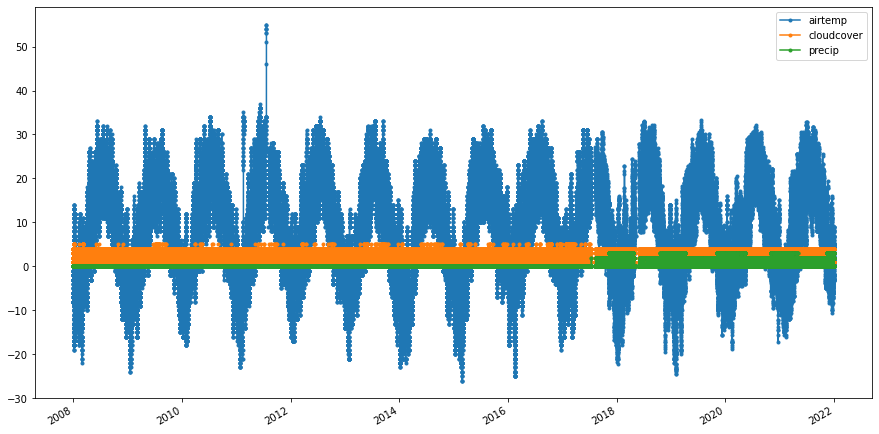

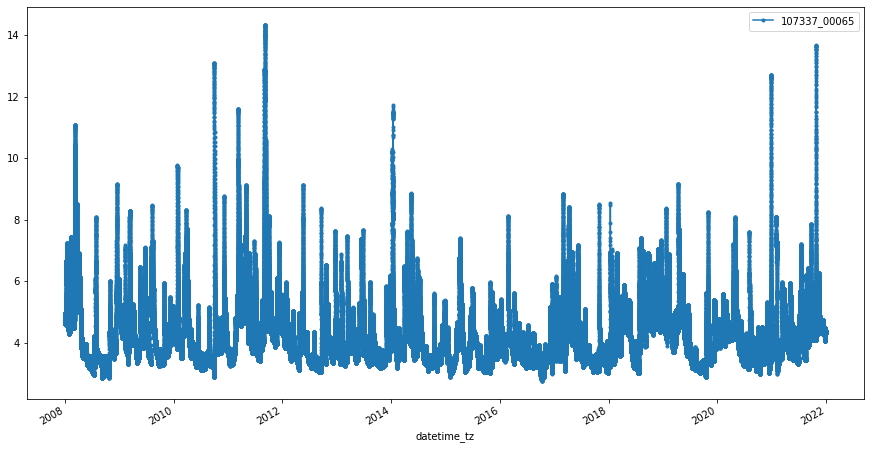

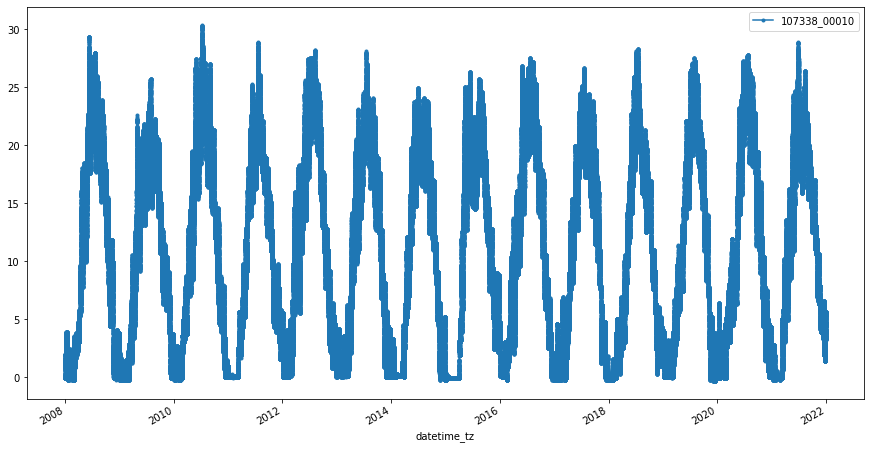

In [23]:
# noaa

noaa_df.plot(style='.-')
plt.show()

# usgs

gageheight_df.plot(style='.-')
plt.show()
watertemp_df.plot(style='.-')
plt.show()

## Interpolate and Resample Dataframes

In [24]:
# noaa

# get indices
oidx = noaa_df.index
nidx = pd.date_range(oidx.min().round('15min'), oidx.max().round('15min'), freq='15min')

# reindex with index union
noaa_df = noaa_df.reindex(oidx.union(nidx))

# interpolate airtemp, cloudcover linearly
noaa_df['airtemp'].interpolate('linear', inplace=True)
noaa_df['cloudcover'].interpolate('linear', inplace=True)
# interpolate precip with pad
noaa_df['precip'].interpolate('pad', inplace=True)

# reindex with new (consistent)
noaa_df = noaa_df.reindex(nidx)

print(noaa_df.head())

# usgs is already the correct freq

gageheight_df.interpolate('linear', inplace=True)
watertemp_df.interpolate('linear', inplace=True)

print(gageheight_df.head())
print(watertemp_df.head())

                           airtemp  cloudcover  precip
2008-01-01 00:00:00+00:00     -2.0         NaN     0.0
2008-01-01 00:15:00+00:00     -3.0         NaN     0.0
2008-01-01 00:30:00+00:00     -3.0         NaN     0.0
2008-01-01 00:45:00+00:00     -3.0         NaN     0.0
2008-01-01 01:00:00+00:00     -3.0         NaN     0.0
                           107337_00065
datetime_tz                            
2008-01-01 00:00:00-05:00          4.89
2008-01-01 00:15:00-05:00          4.89
2008-01-01 00:30:00-05:00          4.89
2008-01-01 00:45:00-05:00          4.88
2008-01-01 01:00:00-05:00          4.88
                           107338_00010
datetime_tz                            
2008-01-01 00:00:00-05:00           2.0
2008-01-01 00:15:00-05:00           1.9
2008-01-01 00:30:00-05:00           2.0
2008-01-01 00:45:00-05:00           1.9
2008-01-01 01:00:00-05:00           1.9


## Combine Datasets

                           airtemp  cloudcover  precip  107337_00065  \
2008-01-01 06:15:00+00:00     -7.0         2.0     0.0          4.88   
2008-01-01 06:30:00+00:00     -7.5         3.0     0.0          4.88   
2008-01-01 06:45:00+00:00     -8.0         3.0     0.0          4.88   
2008-01-01 07:00:00+00:00     -7.5         1.9     0.0          4.88   
2008-01-01 07:15:00+00:00     -7.0         1.8     0.0          4.87   
2008-01-01 07:30:00+00:00     -7.0         1.7     0.0          4.87   
2008-01-01 07:45:00+00:00     -6.5         1.5     0.0          4.87   
2008-01-01 08:00:00+00:00     -6.0         1.3     0.0          4.87   
2008-01-01 08:15:00+00:00     -6.0         1.2     0.0          4.86   
2008-01-01 08:30:00+00:00     -6.0         1.1     0.0          4.87   
2008-01-01 08:45:00+00:00     -6.0         2.0     0.0          4.86   
2008-01-01 09:00:00+00:00     -6.0         3.0     0.0          4.86   
2008-01-01 09:15:00+00:00     -6.0         3.0     0.0          

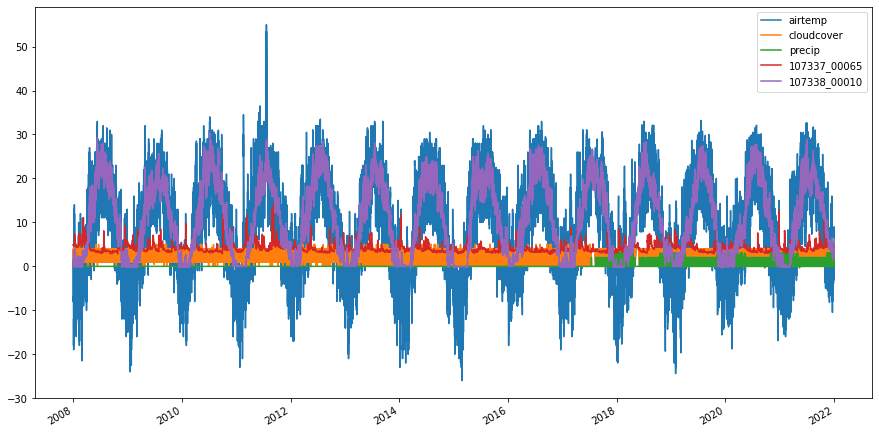

In [25]:
observations = noaa_df.join(gageheight_df, how='outer').join(watertemp_df, how='outer')
observations.dropna(axis='index', inplace=True)

print(observations.head(20))
observations.plot()
plt.show()

## Pickle

In [26]:
observations.to_pickle('output/observations.pickle')